In [65]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import math

In [27]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [67]:
batch_size = 128
epochs = 100
log_interval = 10
img_dims = 10000
x_dim = int(math.sqrt(img_dims))
y_dim = int(math.sqrt(img_dims))

## Load data

In [57]:
def load_dataset(data_path):
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transforms.Compose([torchvision.transforms.Grayscale(),
                                      torchvision.transforms.ToTensor()])
    )
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=0,
        shuffle=True
    )
    return data_loader

train_loader = load_dataset('../data/fruits-360/Training')
test_loader = load_dataset('../data/fruits-360/Test')

## Example image

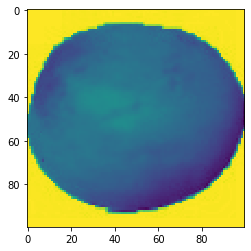

In [58]:
img = next(iter(train_loader))[0][0]
img = img.permute(1, 2, 0)
img = img.view(img.shape[0], img.shape[1])
img.shape
plt.figure()
plt.imshow(img.numpy())
plt.show()

## Model

In [59]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(img_dims, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, img_dims)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, img_dims))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [60]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [61]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, img_dims), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [62]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [68]:
import os
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, x_dim, y_dim)[:n]])
                os.makedirs('results', exist_ok=True)
                save_image(comparison.cpu(),
                         'results/reconstruction_' + str(epoch) + '.png', nrow=n)
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [69]:
if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(batch_size, 20).to(device)
            sample = model.decode(sample).cpu()
            save_image(sample.view(64, 1, x_dim, y_dim),
                       'results/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/55413 (0%)]	Loss: 4421.883301
Train Epoch: 1 [1280/55413 (2%)]	Loss: 4317.680664
Train Epoch: 1 [2560/55413 (5%)]	Loss: 4362.125488


KeyboardInterrupt: 